In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw11.ok')

Assignment: Homework 11: Regression Inference
OK, version v1.12.5



# Homework 11: Regression Inference

**Reading**: 
* [Inference for Regression](https://www.inferentialthinking.com/chapters/16/inference-for-regression.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the provided tests. Each time you start your server, you will need to execute this cell again to load the tests.

Homework 11 is due **Thursday, 4/25 at 11:59 pm**. You will receive an early submission bonus point if you turn in your final submission by Wednesday, 4/24 at 11:59pm. Start early so that you can come to office hours if you're stuck. Check the website for the office hours schedule. Late work will not be accepted as per the [policies](http://data8.org/sp19/policies.html) of this course. 

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

For all problems that you must write our explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook! For example, if you use `max_temperature` in your answer to one question, do not reassign it later on.

In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from client.api.notebook import Notebook
ok = Notebook('hw11.ok')

Assignment: Homework 11: Regression Inference
OK, version v1.12.5



## 1. Quantifying Sampling Errors in Regression


Previously, in this class we've used confidence intervals to quantify uncertainty about estimates as well as to test predictions. To run a hypothesis test using a confidence interval, we use the following procedure:
1. Formulate a null hypothesis; parameter = specific value.
2. Formulate an alternative hypothesis that negates the null hypothesis; parameter != specific value.
3. Choose a statistic to estimate the parameter.
4. Bootstrap, finding a value of the statistic for each resample.
5. Generate a 95% confidence interval from those resampled statistics.
6. Based on whether the value specified in the null is in the interval, make a conclusion.

Another topic we've covered recently is the use of linear regression to make predictions, using correlated variables. An example is, say, predicting the height of children based on the heights of their parents.

We can combine these two topics together in order to make even more powerful statements about our population given just a sample as before. We can use the following techniques to do so:
- Bootstrapped interval for the true slope
- Bootstrapped prediction interval for y (given a particular value of x)

This homework further explores these two advanced methods.

Recall the Old Faithful dataset from our lab on regression. The table contains two pieces of information about each eruption of the Old Faithful geyser in Yellowstone National Park:
1. The duration of the eruption, in minutes.
2. The time between this eruption and the next eruption (the "waiting time"), in minutes.

The dataset only containing durings greater than or equal to three is plotted below along with its line of best fit.

duration,wait
3.6,79
3.333,74
4.533,85
4.7,88
3.6,85
4.35,85
3.917,84
4.2,78
4.7,83
4.8,84


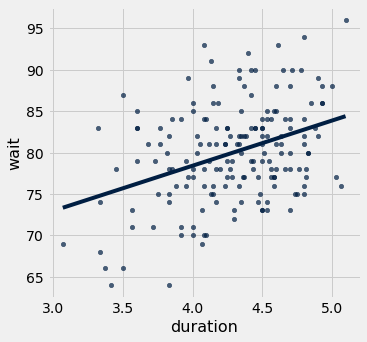

In [3]:
faithful = Table.read_table('faithful_inference.csv').where("duration", are.above_or_equal_to(3))
faithful.scatter('duration', fit_line=True)
faithful

### Finding the Bootstrap Confidence Interval for the True Slope

Looking at this dataset, we can notice the apparent linear relationship between duration and wait for durations greater than or equal to three.  However, our data are just a sample of all the eruptions that have happened at Old Faithful. As we know, relationships can appear in a sample that don't really exist in the population from which the sample was taken.

#### Question 1

Before we move forward using our linear model, we would like to know whether or not there truly exists a relationship between duration and wait time. If there is no relationship between the two, then we'd expect a correlation of 0, which would give us a slope of 0. Now, write in null and alternative hypotheses, based on your knowledge of hypothesis tests you've conducted in the past.

<!--
BEGIN QUESTION
name: q1_1
manual: true
-->
<!-- EXPORT TO PDF -->

The null hypothesis is that there is no relationship and the alternative is that there is a relationship between duration and wait time

#### Question 2

We will use the method of confidence intervals to test this hypothesis.

We'll warm up by implementing some familiar functions. You may use these functions throughout this assignment. Start by defining these two functions:

1. `standard_units` should take in an array of numbers and return an array containing those numbers converted to standard units.
2. `correlation` should take in a table with 2 columns and return the correlation between these columns. 

<!--
BEGIN QUESTION
name: q1_2
manual: false
-->

In [4]:
def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)

def correlation(tbl):
    product = (standard_units(tbl.column(0))) * (standard_units(tbl.column(1)))
    return np.average(product)


In [5]:
ok.grade("q1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3

Using the functions you just implemented, create a function called `fit_line`.  It should take a table as its argument.  It should return an array containing the slope and intercept of the regression line (in that order) that predicts the second column in the table using the first.

<!--
BEGIN QUESTION
name: q1_3
manual: false
-->

In [6]:
def fit_line(tbl):
    x = tbl.column(0)
    y = tbl.column(1)
    r = np.mean((standard_units(x))*(standard_units(y)))
    x_mean = np.average(tbl.column(0))
    y_mean = np.average(tbl.column(1))
    x_sd = np.std(tbl.column(0))
    y_sd = np.std(tbl.column(1))
    slope = r * (y_sd/x_sd)
    intercept = y_mean-slope*x_mean
    return make_array(slope, intercept)

fit_line(faithful)

array([ 5.43881507, 56.64896878])

In [7]:
ok.grade("q1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



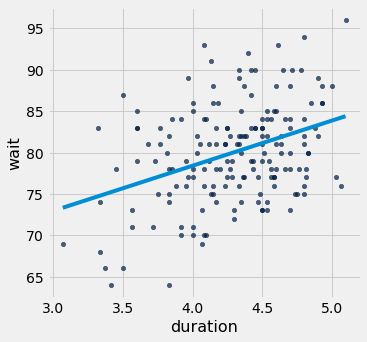

In [8]:
# Ensure your fit_line function fits a reasonable line 
# to the data in faithful, using the plot below

slope, intercept = fit_line(faithful)
faithful.scatter(0)
plt.plot([min(faithful[0]), max(faithful[0])], 
         [slope*min(faithful[0])+intercept, slope*max(faithful[0])+intercept])
plt.show()

Now we have all the tools we need in order to create a confidence interval quantifying our uncertainty about the true relationship between duration and wait time.

#### Question 4

Use the bootstrap to compute 1000 resamples from our dataset. For each resample, compute the slope of the best fit line. Put these slopes in an array called `resample_slopes` in order to generate an empirical distribution of regression line slopes in resamples. Plot a histogram of these slopes.

<!--
BEGIN QUESTION
name: q1_4
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

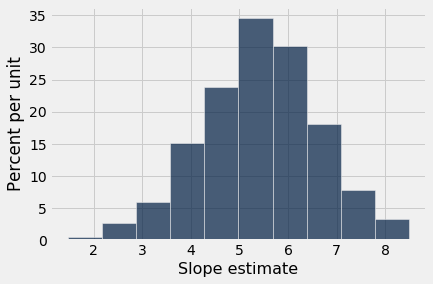

In [9]:
resample_slopes = make_array()
for i in np.arange(1000): 
    sample = faithful.sample()
    resample_line = fit_line(sample)
    resample_slope = resample_line.item(0)
    resample_slopes = np.append(resample_slopes, resample_slope)

Table().with_column("Slope estimate", resample_slopes).hist() # DO NOT CHANGE THIS LINE

#### Question 5

Use your resampled slopes to construct an approximate 95% confidence interval for the true value of the slope.

<!--
BEGIN QUESTION
name: q1_5
manual: false
-->

In [10]:
lower_end = percentile(2.5, resample_slopes)
upper_end = percentile(97.5, resample_slopes)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for slope: [2.89266, 7.71234]


In [11]:
ok.grade("q1_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 6

Based on your confidence interval, would you accept or reject the null hypothesis that the true slope is 0?  Why?  What P-value cutoff are you using?

<!--
BEGIN QUESTION
name: q1_6
manual: true
-->
<!-- EXPORT TO PDF -->

We would reject the null hypothesis of the true slope being 0 because this does not fall in the confidence interval range of [3.09231, 7.63495]. We can also use the 5% cutoff for the p-value.

#### Question 7

If you think the true slope is not 0, what do you think it is? You do not need an exact number.

**Hint:** Can you provide an interval for which you think the true slope falls in?

<!--
BEGIN QUESTION
name: q1_7
manual: true
-->
<!-- EXPORT TO PDF -->

The true slope value falls within the calculated values of approximately [3.09231, 7.63495]. This is true becuase this is where 95% of the data of the sample is.

### Finding the Bootstrap Prediction Interval

Suppose we're tourists at Yellowstone, and we'd like to know how long we'll have to wait for the next Old Faithful eruption.  We decide to use our regression line to make some predictions for the waiting times.  But just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions we'd make based on the true regression line.

#### Question 8

Define the function `fitted_value`.  It should take 2 arguments:

1. A table with 2 columns.  We'll be predicting the values in the second column using the first.
2. A number, the value of the predictor variable for which we'd like to make a prediction.

Make sure to use your `fit_line` function.

<!--
BEGIN QUESTION
name: q1_8
manual: false
-->

In [12]:
def fitted_value(table, given_x):
    line = fit_line(table)
    a = line.item(0)
    b = line.item(1)
    return a * given_x + b

# Here's an example of how fitted_value is used.  This should
# compute the prediction for the wait time of an eruption that lasts 
# two minutes .
two_minutes_wait = fitted_value(faithful, 2)
two_minutes_wait

67.52659892156797

In [13]:
ok.grade("q1_8");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 9

The park ranger tells us that the most recent eruption lasted 6 minutes. Using your function above, assign the variable `most_recent_wait` to the predicted wait time for the next eruption. 

<!--
BEGIN QUESTION
name: q1_9
manual: false
-->

In [14]:
most_recent_wait = fitted_value(faithful,6)
most_recent_wait

89.28185919744949

In [15]:
ok.grade("q1_9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Juan, a fellow tourist, raises the following objection to your prediction:

> "Your prediction depends on your sample of 272 eruptions.  Couldn't your prediction have been different if you had happened to have a different sample of eruptions?"

Having read section [16.3](https://www.inferentialthinking.com/chapters/16/3/prediction-intervals.html) of the textbook, you know just the response!

#### Question 10

Define the function `compute_resampled_line`. It should take in a table, and should return the parameters of the best fit line for one resampling of the table.

`tbl` is a table with two columns. We'll be predicting the second column using the first.

<!--
BEGIN QUESTION
name: q1_10
manual: false
-->

In [16]:
def compute_resampled_line(tbl):
    resample = tbl.sample()
    resampled_line = fit_line(resample)
    return resampled_line

**Run** the following cell below in order to define the function `bootstrap_lines`.  It takes in two arguments:
1. A table with two columns.  As usual, we'll be predicting the second column using the first.
2. An integer, a number of bootstraps to run.

It returns a *table* whose first column, `Slope`, contains the given number of bootstrapped slopes, and whose second column, `Intercept`, contains the corresponding bootstrapped intercepts.  Each slope and intercept should come from a regression line that predicts column 2 from column 1 of a resample of the given table.  The table should have 1 row for each bootstrap replication.

In [17]:
def bootstrap_lines(tbl, num_bootstraps):
    resampled_slopes = make_array()
    resampled_intercepts = make_array() 
    for _ in range(num_bootstraps): 
        resampled_line = compute_resampled_line(tbl) 
        resampled_slope = resampled_line.item(0) 
        resampled_intercept = resampled_line.item(1) 
        resampled_slopes = np.append(resampled_slopes,resampled_slope)
        resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
    tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
    return tbl_lines

regression_lines = bootstrap_lines(faithful, 1000)
regression_lines

Slope,Intercept
6.66623,51.2903
6.15943,54.2254
7.1425,49.4587
6.24729,52.6333
4.38748,61.4164
4.24266,61.9809
4.40696,60.7617
4.82513,58.7721
4.8484,59.7218
6.42841,52.3356


#### Question 11

Create an array called `predictions_for_six`.  It should contain 1000 numbers.  Each number should be the predicted waiting time after an eruption with a duration of 6 minutes, using a different bootstrapped regression line. 

**Hint:** Use `regression_lines` from the previous questions along with array operations!

<!--
BEGIN QUESTION
name: q1_11
manual: true
image: true
-->
<!-- EXPORT TO PDF -->

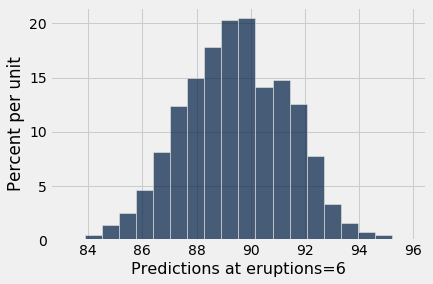

In [18]:
predictions_for_six = (regression_lines.column(0)*6)+regression_lines.column(1)

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at eruptions=6', predictions_for_six)
table_of_predictions.hist('Predictions at eruptions=6', bins=20)

#### Question 12

Create an approximate 95 percent confidence interval for these predictions.

<!--
BEGIN QUESTION
name: q1_12
manual: false
-->

In [19]:
lower_bound = percentile(2.5, predictions_for_six)
upper_bound = percentile(97.5, predictions_for_six)

print('95% Confidence interval for predictions for x=6: (', lower_bound,",", upper_bound, ')')

95% Confidence interval for predictions for x=6: ( 85.66739906826552 , 93.13862116698621 )


In [20]:
ok.grade("q1_12");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



In [21]:
lower_bound > 80 and upper_bound < 101

True

#### Question 13

Look at the scatter plot of the data at the start of this exercise. 
Determine which of the following are true, then set `question_12_choice` to an array consisting of the number(s) of statement(s) that are true. For example, if you think that 1 and 2 are true but 3 is false, you'd assign `question_12_choice` to be an array consisting of the values 1 and 2.

Statement 1: This confidence covers 95 percent of waiting times of eruptions in `faithful` that had an eruption duration of 6 minutes.

Statement 2: This interval gives a sense of how much actual wait times differ from your prediction.

Statement 3: The approximate 95% confidence interval quantifies our uncertainty in our estimate of what the true line would predict.

<!--
BEGIN QUESTION
name: q1_13
manual: false
-->

In [22]:
question_12_choice = [1,3]

In [23]:
ok.grade("q1_13");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## 2. Submission


Once you're finished, select "Save and Checkpoint" in the File menu and then execute the `submit` cell below. The result will contain a link that you can use to check that your assignment has been submitted successfully. If you submit more than once before the deadline, we will only grade your final submission. If you mistakenly submit the wrong one, you can head to [okpy.org](https://okpy.org/) and flag the correct version. To do so, go to the website, click on this assignment, and find the version you would like to have graded. There should be an option to flag that submission for grading!

In [24]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw11.ipynb'.
Submit... 100% complete
Submission successful for user: shivanijpatel@berkeley.edu
URL: https://okpy.org/cal/data8/sp19/hw11/submissions/oV0YNk



In [60]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t